In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Test 1: Scalar ODE with 1 parameter

$$ y' = exp(-t) - \alpha y \quad y(0) = 0 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 1
n_odeparams = 1

#Times to evaluate the solution
data = make_test_data_1()
times = data['t']
# times = np.arange(0.25,8,0.25)

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_1, 
                    t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

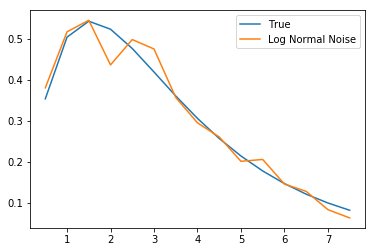

In [3]:

Ytrue = data['y']
Y = data['yobs']

plt.plot(times, Ytrue, label = 'True')
plt.plot(times, Y, label = 'Log Normal Noise')

plt.legend()

In [ ]:
my_ODEop = ODEop(ode_model)

In [ ]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    alpha = pm.HalfNormal('alpha',1)

    sigma = pm.HalfCauchy('sigma',1)

    # Forward model
    # [ODE parameter, Initial Condition]
    all_params = pm.math.stack([alpha, 0],axis=0)

    
    ode_sol = my_ODEop(all_params)

    forward = ode_sol.reshape(Y.shape)
    
    ode = pm.Deterministic('ode',ode_sol)
        
    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains:  77%|███████▋  | 4624/6000 [02:03<00:29, 45.93draws/s]

In [ ]:
alpha = data['p'][0]
y0 = 0
sigma = data['sigma']
pm.posteriorplot.plot_posterior(trace,varnames = ['alpha','sigma'], ref_val=[alpha, sigma]);

In [ ]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

In [ ]:
with first_model:
    ppc = pm.sample_ppc(trace, 2000)

In [ ]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5);
    
plt.plot(times,Y, color = 'red');
plt.title('Posterior Predictive Check')

In [ ]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.25);
    
plt.plot(times,Ytrue, color = 'red');

In [ ]:
%timeit ode_model.cached_simulate([np.random.uniform(),0])